Files already downloaded and verified
Files already downloaded and verified
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([64, 3, 11, 11])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([64])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([192, 64, 5, 5])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([192])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([384, 192, 3, 3])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([384])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([256, 384, 3, 3])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([256])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([256, 256, 3, 3])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([256])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size: torch.Size([10, 256])
[] Type: <class 'torch.nn.parameter.Parameter'>,  size

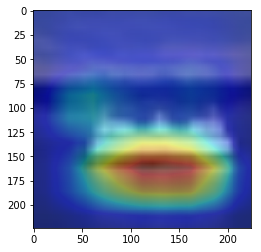

[] Label: ship
[] Predict: ship


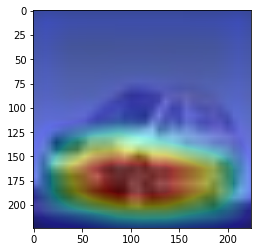

[] Label: car
[] Predict: car


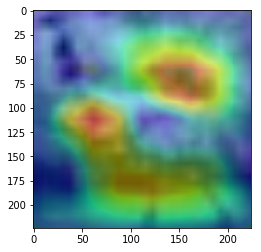

[] Label: bird
[] Predict: frog


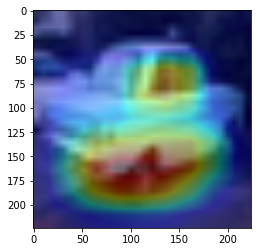

[] Label: car
[] Predict: car


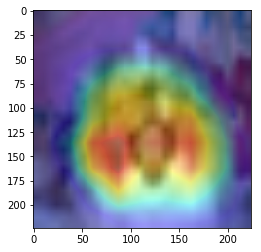

[] Label: dog
[] Predict: dog


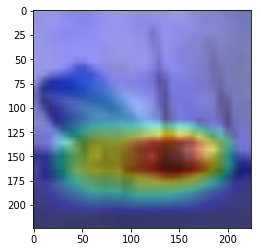

[] Label: plane
[] Predict: truck


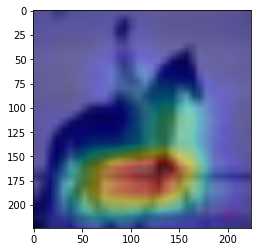

[] Label: horse
[] Predict: horse


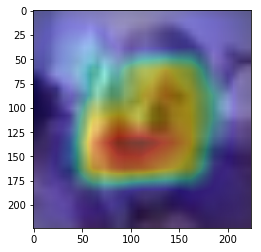

[] Label: dog
[] Predict: dog


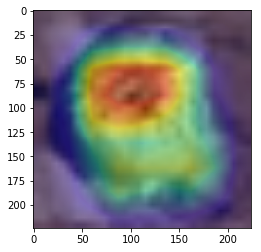

[] Label: bird
[] Predict: frog


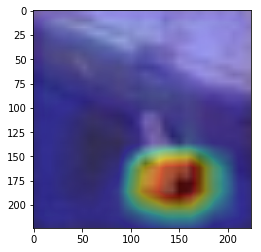

[] Label: frog
[] Predict: truck


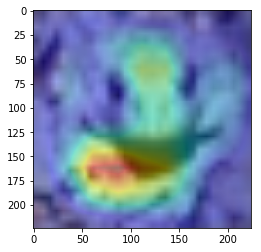

[] Label: frog
[] Predict: frog


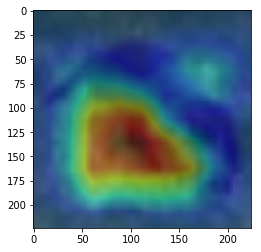

[] Label: dog
[] Predict: deer


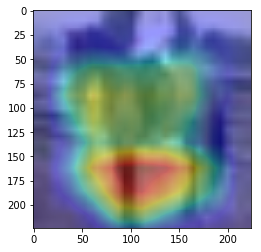

[] Label: horse
[] Predict: horse


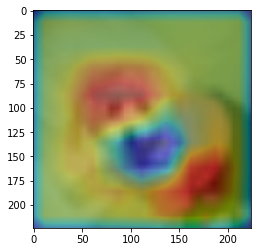

[] Label: dog
[] Predict: frog


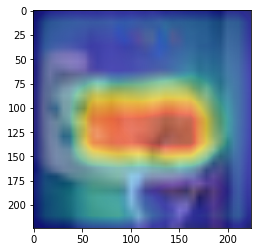

[] Label: dog
[] Predict: cat


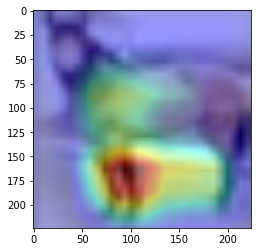

[] Label: horse
[] Predict: horse


In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import skimage.transform

class AlexNet(nn.Module):
    def __init__(self, class_num):
        super(AlexNet, self).__init__()
        self.feature_network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = (11, 11), stride = 4, padding = 5),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.classifier_network = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 1 * 1, class_num)
        )
        
        
    def forward(self, x):
        avg = nn.AvgPool2d(9)
        
        f1 = self.feature_network(x)
#         print('[]f1 size: ', f1.size())
        f2 = avg(f1)
#         print('[] f2 size: ', f2.size())
        f3 = f2.view(-1, 256 * 1 * 1)
        result = self.classifier_network(f3)
        
        return result, f1
    

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
#     print('[] npimg shape: ', npimg.shape)
    t = np.transpose(npimg, (1, 2, 0))
#     print('[] shape: ', t.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     print('[] npimg shape: ', npimg.shape)


def main():
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    AN = AlexNet(len(classes))
    
    transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root = './data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root = './data', train=False, download = True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True, num_workers=2)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(AN.parameters(), lr=0.001, momentum=0.9)
    
    AN.to(device)
    
    param = list(AN.parameters())
    for p in param:
        print("[] Type: {},  size: {}".format(type(p), p.size()))
    
    for epoch in range(0, 20):
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
#             print('[] Input size: ', inputs.size())
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, F = AN.forward(inputs)
#             print('[] outputs shape: ', outputs.size())
#             print('[] labels shape: ', labels.size())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0
                
                
    class_correct = list(0 for i in range(10))
    class_total = list(0 for i in range(10))
    
    
    with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs, F = AN.forward(images)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
    
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
    
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    
    print('[] Save network ')
    torch.save(AN, 'AlexnetCAM.pt')
    param = list(AN.parameters())
    W = param[-2].cpu().data.numpy()

    print('[] Weight size: ', W[1].shape)
    print('[] F size: ', F.size())
    
    t = F[0].reshape([256, 81])
    # print(F[0])
    # print(t)
    
    # F -> before AvgPooling
    for i in range(0, 16):
        pred_val = predicted[i].item()
        label_val = labels[i].item()
    #     print(i)
        
        # Make CAM picture 
        CAM_img = W[pred_val].dot(F[i].reshape([256, 81]))
        CAM_img = CAM_img.reshape(9, 9)
        
        CAM_img -= CAM_img.min()
        CAM_img /= CAM_img.max()
        
        imshow(images[i].cpu())
#         plt.show()
        
        #CAM = skimage.transform.resize(CAM_img, (224, 224), mode = 'constant')
        CAM = skimage.transform.resize(CAM_img, (224, 224))
        plt.imshow(CAM, alpha = 0.4, cmap = 'jet')
        plt.show()
        print('[] Label: {}\n[] Predict: {}'.format(classes[label_val], classes[pred_val]))
                    
#     print('[] F: ' ,F.size())
    
if __name__ == '__main__':
    main()
    